In [1]:
import torch
import numpy as np
from etnn.nn.layer_framework import LayerManagementFramework, TreeNode
import random
import matplotlib.pyplot as plt

In [2]:
def seeding_all(seed: int = 420):
    # Set the random seed for reproducibility
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [3]:
# create elements
a = torch.tensor([1., 2., -3., 4., 5., 6.])
b = torch.tensor([2., -3., 4., 5., 6., 7.])
c = torch.tensor([ 3., 4., 5., 6., -7., 8.])
d = torch.tensor([-1., -2., -3., -4., -5., -6.])

In [4]:
# create data points
data = torch.stack([
    torch.stack([a, b, c, d]),
    torch.stack([d, b, c, a])
])
labels = torch.tensor([
    0., 1.
])

In [5]:
# backup 1
data = torch.stack([
    torch.stack([a, b, c, d]),
    torch.stack([d, a, b, c]),
    torch.stack([c, d, a, b]),
    # torch.stack([b, c, d, a]),

    torch.stack([d, b, c, a]),
    torch.stack([a, d, b, c]),
    torch.stack([c, a, d, b]),
    # torch.stack([b, c, a, d]),
])
labels = torch.tensor([
    0.,
    0.,
    0.,
    # 0.,
    30.,
    30.,
    30.,
    # 30.
])
data_test = torch.stack([
    torch.stack([b, c, d, a]),
    torch.stack([b, c, a, d]),
])
labels_test = torch.tensor([
    0.,
    30.
])

In [6]:
# alternative data
data = torch.stack([
    torch.stack([a, b, c, d]),
    torch.stack([d, a, b, c]),
    torch.stack([c, d, a, b]),
    torch.stack([b, c, d, a]),

    torch.stack([d, b, c, a]),
    torch.stack([a, d, b, c]),
    torch.stack([c, a, d, b]),
    torch.stack([b, c, a, d]),
])
labels = torch.tensor([
    0.,
    0.,
    0.,
    0.,
    30.,
    30.,
    30.,
    30.
])
data_test = torch.stack([
    torch.stack([d,c,b,a]),
    torch.stack([a,c,b,d])
])
labels_test = torch.tensor([
    0.,
    30.
])

In [7]:
# construct tree:
tree = TreeNode("C", [TreeNode("E", 4)])

In [8]:
# tree = TreeNode("Q", [TreeNode("E", 4)])

In [9]:
num_epochs = 1000
learning_rate = 0.001

In [10]:
# test run for both models
print("etnn")
train_loss_storage_etnn = []
test_loss_storage_etnn = []

# seed for fair comparison and reproducability
seeding_all()

etnn_model = LayerManagementFramework(
    in_dim=6,
    tree=tree,
    hidden_dim=10,
    out_dim=1,
    k=2
)
print(f"parameter counter: {sum([p.numel() for p in etnn_model.parameters()])}")

# create optimizer and loss
criterion = torch.nn.L1Loss()
optimizer = torch.optim.Adam(etnn_model.parameters(), lr=learning_rate)

# do for some epochs
for epoch in range(num_epochs):
    # train
    optimizer.zero_grad()
    etnn_model.train()
    out = etnn_model(data)
    train_loss = criterion(out.flatten(), labels)
    train_loss_storage_etnn += [train_loss.item()]
    train_loss.backward()
    optimizer.step()

    # test
    with torch.no_grad():
        etnn_model.eval()
        test_loss = criterion(etnn_model(data_test).flatten(), labels_test)
        test_loss_storage_etnn += [test_loss.item()]
    print(f"epoch: {epoch}| train_loss: {train_loss} | test_loss: {test_loss} \nvalues: {out.flatten().detach().cpu().tolist()}")

etnn
parameter counter: 470
epoch: 0| train_loss: 15.445501327514648 | test_loss: 15.390996932983398 
values: [-0.44774699211120605, -0.44774696230888367, -0.4477469325065613, -0.44774699211120605, -0.4432560205459595, -0.44325605034828186, -0.4432560205459595, -0.44325605034828186]
epoch: 1| train_loss: 15.390997886657715 | test_loss: 15.3364896774292 
values: [-0.3918900787830353, -0.39189010858535767, -0.39189010858535767, -0.39189010858535767, -0.3901042342185974, -0.3901042342185974, -0.3901042640209198, -0.3901042938232422]
epoch: 2| train_loss: 15.336490631103516 | test_loss: 15.281087875366211 
values: [-0.3360603153705597, -0.3360602855682373, -0.3360602855682373, -0.3360603153705597, -0.33692067861557007, -0.33692067861557007, -0.3369206190109253, -0.3369206190109253]
epoch: 3| train_loss: 15.281087875366211 | test_loss: 15.211073875427246 
values: [-0.2784661650657654, -0.2784661054611206, -0.2784661054611206, -0.2784661054611206, -0.28370991349220276, -0.28370994329452515, 

In [11]:
# test run for both models
print("baseline")
train_loss_storage_baseline = []
test_loss_storage_baseline = []

# seed for fair comparison and reproducability
seeding_all()

baseline = torch.nn.Sequential(
    torch.nn.Linear(6*4,9*2),
    torch.nn.ReLU(),
    torch.nn.Linear(9*2, 1)
)

print(f"parameter counter: {sum([p.numel() for p in baseline.parameters()])}")

# create optimizer and loss
criterion = torch.nn.L1Loss()
optimizer = torch.optim.Adam(baseline.parameters(), lr=learning_rate)

# do for some epochs
for epoch in range(num_epochs):
    # train
    optimizer.zero_grad()
    baseline.train()
    out = baseline(data.reshape(data.shape[0], -1))
    train_loss = criterion(out.flatten(), labels)
    train_loss_storage_baseline += [train_loss.item()]
    train_loss.backward()
    optimizer.step()

    # test
    with torch.no_grad():
        etnn_model.eval()
        test_loss = criterion(baseline(data_test.reshape(data_test.shape[0], -1)).flatten(), labels_test)
        test_loss_storage_baseline += [test_loss.item()]
    print(f"epoch: {epoch}| train_loss: {train_loss} | test_loss: {test_loss} \nvalues: {out.flatten().detach().cpu().tolist()}")

baseline
parameter counter: 469
epoch: 0| train_loss: 14.952322006225586 | test_loss: 15.171659469604492 
values: [0.7143006920814514, 1.8277544975280762, 0.4007085859775543, -0.07545320689678192, 0.9702562093734741, 1.9368338584899902, 0.9966623187065125, -0.5041199922561646]
epoch: 1| train_loss: 14.91673469543457 | test_loss: 15.173028945922852 
values: [0.6882786154747009, 1.7892926931381226, 0.40598058700561523, -0.004400581121444702, 0.9911823868751526, 1.9603850841522217, 1.0682647228240967, -0.4657566547393799]
epoch: 2| train_loss: 14.898882865905762 | test_loss: 15.172628402709961 
values: [0.6661264300346375, 1.7520866394042969, 0.41074395179748535, 0.07337750494480133, 1.01446533203125, 1.9841337203979492, 1.1408449411392212, -0.4281778931617737]
epoch: 3| train_loss: 14.879316329956055 | test_loss: 15.170989036560059 
values: [0.6447250843048096, 1.7183372974395752, 0.4101288914680481, 0.11855481564998627, 1.0395532846450806, 2.0103840827941895, 1.2010852098464966, -0.3938

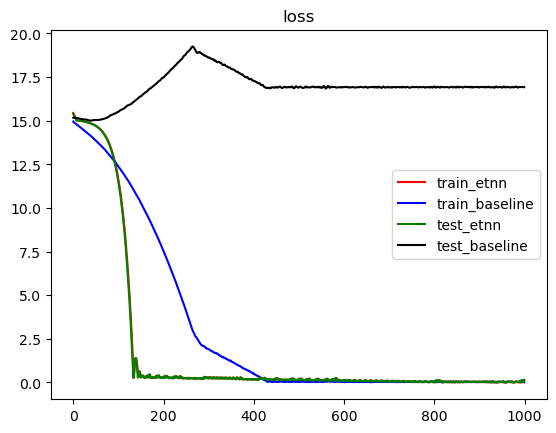

In [12]:
# plot stuff
plt.figure()
plt.plot(train_loss_storage_etnn, c='r', label="train_etnn")
plt.plot(train_loss_storage_baseline, c='b', label="train_baseline")

plt.plot(test_loss_storage_etnn, c='green', label="test_etnn")
plt.plot(test_loss_storage_baseline, c='black', label="test_baseline")
plt.title("loss")
plt.legend()
plt.show()